In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [2]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler(),
    }

param_grid = {
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [3000],
    'module__hidden1_size' : [30, 45, 60],
    'module__hidden2_size' : [9, 11, 13, 15]
}

In [3]:
df = pd.read_excel('data_3nm.xlsx')

In [4]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [5]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [6]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [7]:
# add noise
X_noisy = add_noise(X, args['noise'])

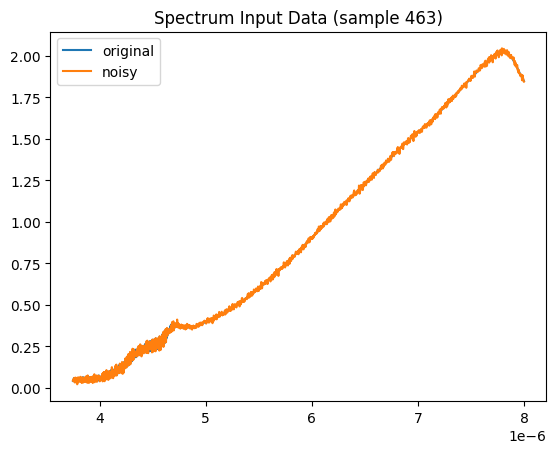

In [8]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [9]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [10]:
X_tensor = torch.tensor(X_noisy_scaled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden1_size, hidden2_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, hidden1_size)
        self.lin2 = nn.Linear(hidden1_size, hidden2_size)
        self.lin_fin = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = self.lin_fin(x)
        return x

In [12]:
input_size = len(X.columns)
output_size = len(y.columns)

In [13]:
net = NeuralNetRegressor(
    module=Net,
    module__input_size=input_size,
    module__output_size=output_size,
    module__hidden1_size=45,
    module__hidden2_size=9,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=3, n_jobs=-1)

gs.fit(X_tensor, y_tensor)

best_model = gs.best_estimator_
best_params = gs.best_params_

print('Best loss: {}'.format(gs.best_score_))
print('Params: {}'.format(best_params))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    62045.6720    21183.9934  0.1012
      2    18239.9532    12367.4730  0.0835
      3     7677.5558     2269.4877  0.0763
      4      878.5309      280.8579  0.0753
      5      218.6184      175.6024  0.0741
      6      159.3087      149.7495  0.0765
      7      136.8235      125.7095  0.0780
      8      114.4992      109.1332  0.0713
      9      100.4853      101.7597  0.0718
     10       90.6817       90.8245  0.0708
     11       81.7586       81.8093  0.0746
     12       75.6993       76.3927  0.0730
     13       72.2990       73.3381  0.0702
     14       70.2949       72.0935  0.0822
     15       69.0730       71.3584  0.1116
     16       68.1846       70.7833  0.0859
     17       67.3003       70.1126  0.0782
     18       66.3685       69.3062  0.0821
     19       65.8021       68.9380  0.0807
     20       6